In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
import warnings

In [3]:
covid_data = pd.read_csv('COVID19_Qc.csv')
covid_data.drop(0, inplace=True)
covid_data['Date'] = pd.to_datetime(covid_data['Date'])
covid_data = covid_data[covid_data['Date'].dt.year != 2023]
covid_data = covid_data[covid_data['Date'] <= '2021-03-05']

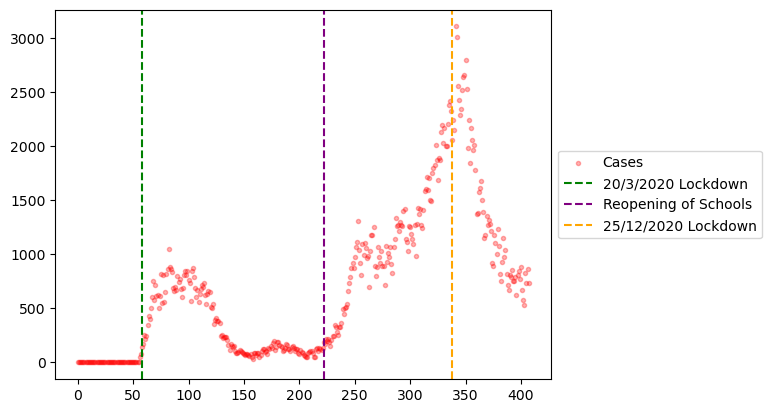

In [4]:
warnings.filterwarnings('ignore')

# Scatter plot

covid_data['days_since_start'] = (covid_data['Date'] - pd.Timestamp('2020-01-23')).dt.days
x = covid_data['days_since_start']
y = covid_data['New_Confirmed_Cases']

#Timestamps for events
e1 = pd.Timestamp('2020-03-20 00:00:00')
e2 = pd.Timestamp('2020-08-31 00:00:00')
e3 = pd.Timestamp('2020-12-25 00:00:00')
e1_i = covid_data[covid_data['Date'] == e1].index[0]
e2_i = covid_data[covid_data['Date'] == e2].index[0]
e3_i = covid_data[covid_data['Date'] == e3].index[0]

y[y < 0] = 0.
fig, ax = plt.subplots()

#Scatter plot data
plt.scatter(x, y,color='red', alpha=0.3, marker='.', label='Cases')

ax.axvline(e1_i, color='green', linestyle='--', label='20/3/2020 Lockdown')
ax.axvline(e2_i, color='purple', linestyle='--', label='Reopening of Schools')
ax.axvline(e3_i, color='orange', linestyle='--', label='25/12/2020 Lockdown')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

20/3/2020 Lockdown:
                             OLS Regression Results                            
Dep. Variable:     New_Confirmed_Cases   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.918
Method:                  Least Squares   F-statistic:                     284.3
Date:                 Wed, 17 Jan 2024   Prob (F-statistic):           1.21e-52
Time:                         13:31:15   Log-Likelihood:                -598.34
No. Observations:                  102   AIC:                             1207.
Df Residuals:                       97   BIC:                             1220.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const       

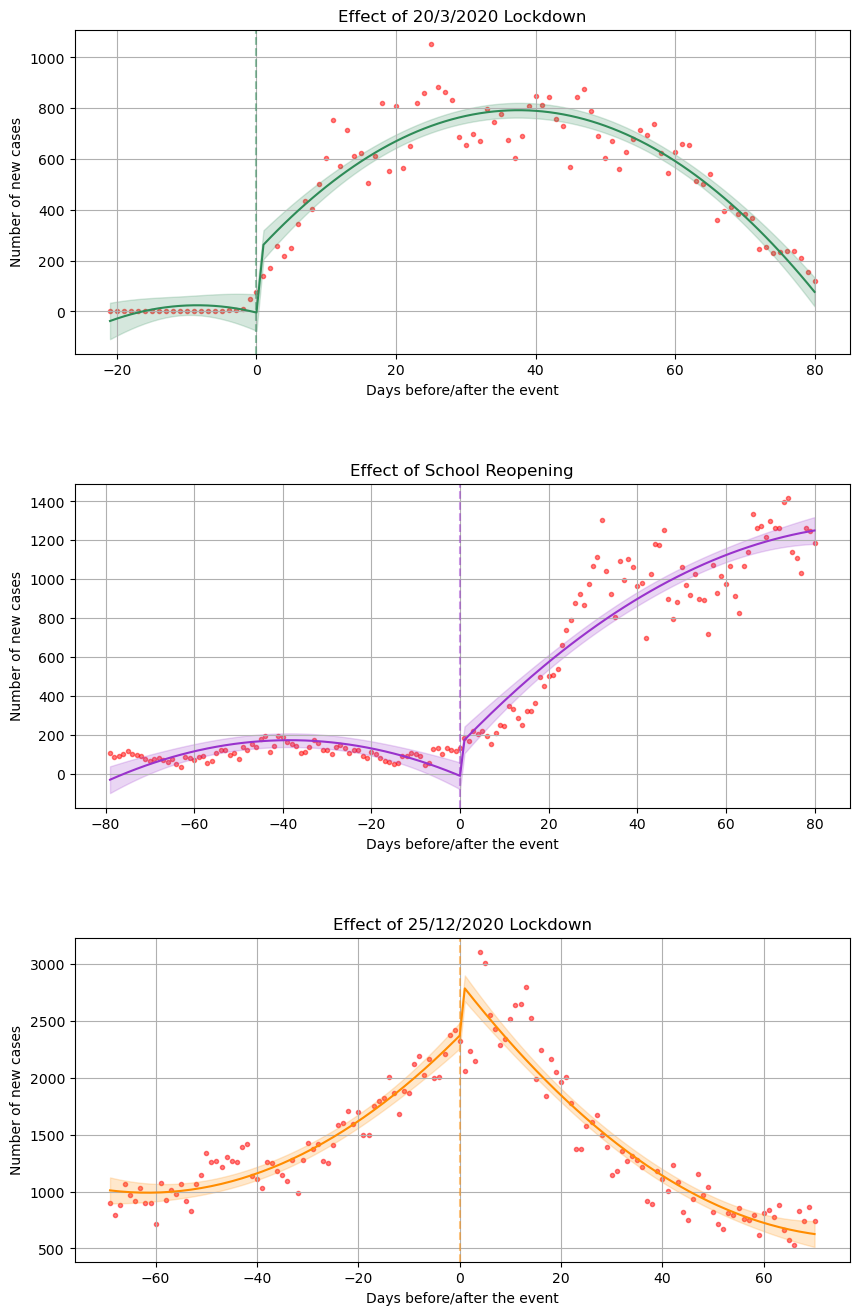

In [13]:
warnings.filterwarnings('ignore')

# Number of days before and after each event
n_days1 = 80
n_days2 = 80
n_days3 = 70
# n_days4 = n_days1
n_days4 = 22

e1_period = covid_data[(e1_i-n_days4):(e1_i+n_days1)]
e1_period['days'] = np.arange(-n_days4+1, n_days1+1)

e2_period = covid_data[(e2_i-n_days2):(e2_i+n_days2)]
e2_period['days'] = np.arange(-n_days2+1, n_days2+1)

e3_period = covid_data[(e3_i-n_days3):(e3_i+n_days3)]
e3_period['days'] = np.arange(-n_days3+1, n_days3+1)

# Event periods and events for iteration
lst = [e1_period, e2_period, e3_period]
lst2 = [e1, e2, e3]
events = ['20/3/2020 Lockdown', 'School Reopening', '25/12/2020 Lockdown']
colors = ['seagreen', 'darkorchid', 'darkorange']

# Lists to store independent and dependent variables for each event period
lstx = []
lsty = []
for i in range(len(lst)):
    df = lst[i]
    df['before_after']=(df['Date']>lst2[i]).astype(int) # dummy
    df['ba_days'] = df['days'] * df['before_after']
    df['days_squared'] = df['days'] ** 2
    df['ba_days_squared'] = df['days'] * df['before_after']
    # dummy, x, x^2, dummy*x and dummy*x^2
    lstx.append(sm.add_constant(df[['days','days_squared', 'before_after', 'ba_days', 'ba_days_squared']]))
    lsty.append(df['New_Confirmed_Cases'])

fig, axs = plt.subplots(3, 1, figsize=(10,16))
plt.subplots_adjust(hspace=0.4)

# Modelling and plotting with days before and after the event on the x-axis
for i in range(len(lstx)):
    est = sm.OLS(lsty[i], lstx[i]).fit()
    conf_int = est.get_prediction(lstx[i]).conf_int(alpha=0.05)
    lower = conf_int[:, 0]
    upper = conf_int[:, 1]
    print(f'{events[i]}:\n{est.summary()}\n')
    axs[i].scatter(lst[i]['days'], lst[i]['New_Confirmed_Cases'], 
                      color='red', alpha=0.5, marker='.', label='Confirmed Cases')
    axs[i].fill_between(lst[i]['days'], lower, upper, color=colors[i], alpha=0.2)
    axs[i].plot(lst[i]['days'], est.predict(lstx[i]), color = colors[i])
    axs[i].axvline(0, color=colors[i], linestyle='--', label=events[i], alpha=0.5)
    axs[i].set_title(f'Effect of {events[i]}')
    axs[i].grid()

for ax in axs.flat:
    ax.set(xlabel='Days before/after the event', ylabel='Number of new cases')

plt.show()